In [1]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install imblearn

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
c = pd.read_excel('polyp_data v2.xlsx')
print(c)

      sex  location  nutrition  reason  history  past_diagnosis  diagnosis  \
0       1         3          2       1        2               4          1   
1       1         3          2       1        2               4          1   
2       1         2          2       1        2               4          3   
3       2         1          2       1        2               4          3   
4       1         2          2       1        2               4          1   
...   ...       ...        ...     ...      ...             ...        ...   
2663    1         1          2       1        2               4          1   
2664    1         1          2       1        1               2          2   
2665    2         2          2       1        2               4          3   
2666    1         1          2       1        2               4          1   
2667    1         2          2       1        2               4          2   

      polyp_loca  polyp_size  polyp_num  ...  polyp_state  path

In [21]:
d = c.iloc[:, 0:16]
d.columns = d.columns.str.strip()
print(d)

      sex  location  nutrition  reason  history  past_diagnosis  diagnosis  \
0       1         3          2       1        2               4          1   
1       1         3          2       1        2               4          1   
2       1         2          2       1        2               4          3   
3       2         1          2       1        2               4          3   
4       1         2          2       1        2               4          1   
...   ...       ...        ...     ...      ...             ...        ...   
2663    1         1          2       1        2               4          1   
2664    1         1          2       1        1               2          2   
2665    2         2          2       1        2               4          3   
2666    1         1          2       1        2               4          1   
2667    1         2          2       1        2               4          2   

      polyp_loca  polyp_size  polyp_num  polyp_shape  polyp_sta

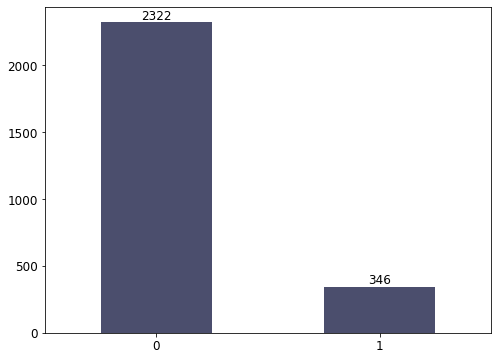

In [22]:
vals = d.intussusception.value_counts()

plt.figure(figsize=(8,6))
plt.rc('font', size=12)

ax = vals.plot.bar(rot=0, color='#4B4E6D')

for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [23]:
X = d.loc[:, d.columns != 'intussusception']
y = d.intussusception
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2668, 15)
y shape: (2668,)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

confusion(y_test, y_pred) 

Accuracy: 90.82%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]         451          17
True[1]          32          34


,Predict[0],Predict[1]
True[0],451,17
True[1],32,34


In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

print(y_train_sm.value_counts())
print(y_test_sm.value_counts())

0    1854
1    1854
Name: intussusception, dtype: int64
0    468
1    468
Name: intussusception, dtype: int64


In [33]:
# After oversampling, the classification result is more reasonable.
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred_sm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(y_test_sm, y_pred_sm), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

Accuracy: 86.54%


,Predict[0],Predict[1]
True[0],428,40
True[1],86,382


In [34]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
#X_test_sm, y_test_sm = smote.fit_sample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
#X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [36]:
print('X train shape: ',X_train_sm.shape)
print('y train values: \n', y_train_sm.value_counts())
print()
print('X test shape: ',X_test_sm.shape)
print('y test values: \n', y_test_sm.value_counts())

X train shape:  (3708, 15)
y train values: 
 0    1854
1    1854
Name: intussusception, dtype: int64

X test shape:  (936, 15)
y test values: 
 0    468
1    468
Name: intussusception, dtype: int64


In [37]:
mscore=[]

In [62]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

max_iter = range(100, 500)
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
#C = np.arange(0, 1, 0.01)
C = [1E-7, 1E-6, 1E-6, 1E-4, 1E-3]
penalty = ['l1', 'l2']
random_grid ={
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'penalty': penalty,
    'C' : C,
}

clf = LogisticRegression(random_state=12)
#scores = cross_validate(clf, X_train_sm, y_train_sm, cv=10, return_train_score=True)
#pd.DataFrame(scores)

search = RandomizedSearchCV(clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=random_grid,
                            refit=True, n_jobs=-1, random_state = 12)
search.fit(X_train_sm, y_train_sm)
clf = search.best_estimator_

clf_ibd_proba = clf.predict_proba(X_test)[:, 1]

y_pred = clf.predict(X_test)
print('Accuracy Score:', clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Logistic Regression', clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

Accuracy Score: 0.8764044943820225
Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/Users/zhiyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhiyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhiyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhiyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line

,Predict[0],Predict[1]
True[0],468,0
True[1],66,0


In [63]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train_sm, y_train_sm, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [64]:
results = {}
results["Logistic Regression"] = mean_std_cross_val_scores(
    clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Logistic Regression,0.031 (+/- 0.013),0.008 (+/- 0.001),0.500 (+/- 0.000),0.500 (+/- 0.000)


In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

log_params = {'penalty': ['l1', 'l2'], 'C': [1E-7, 1E-6, 1E-6, 1E-4, 1E-3]}

dt_clf = DecisionTreeClassifier(max_depth=5, random_state=12, return_estimator=True)

search = RandomizedSearchCV(dt_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
dt_clf = search.best_estimator_

dt_clf_ibd_proba = dt_clf.predict_proba(X_test)[:, 1]

y_pred = dt_clf.predict(X_test)
print('Accuracy Score:', dt_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Decision Tree', dt_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["Decision tree"] = mean_std_cross_val_scores(
    dt_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

random_grid =

rf_clf = RandomForestClassifier(random_state=12)

search = RandomizedSearchCV(rf_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
rf_clf = search.best_estimator_

rf_clf_ibd_proba = rf_clf.predict_proba(X_test)[:, 1]

y_pred = rf_clf.predict(X_test)
print('Accuracy Score:', rf_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Random Forest', rf_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["Random Forest"] = mean_std_cross_val_scores(
    rf_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

random_grid = 

svm_clf = SVC(random_state=12)

search = RandomizedSearchCV(svm_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
svm_clf = search.best_estimator_

svm_clf_ibd_proba = svm_clf.predict_proba(X_test)[:, 1]

y_pred = svm_clf.predict(X_test)
print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['SVM', svm_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["SVM"] = mean_std_cross_val_scores(
    svm_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

random_grid = 

knn_clf = KNeighborsClassifier(random_state=12)

search = RandomizedSearchCV(knn_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
knn_clf = search.best_estimator_

knn_clf_ibd_proba = knn_clf.predict_proba(X_test)[:, 1]

y_pred = knn_clf.predict(X_test)
print('Accuracy Score:', knn_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['KNN', knn_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["KNN"] = mean_std_cross_val_scores(
    knn_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

random_grid = 

nb_clf = GaussianNB(random_state=12)

search = RandomizedSearchCV(nb_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
nb_clf = search.best_estimator_

nb_clf_ibd_proba = nb_clf.predict_proba(X_test)[:, 1]

y_pred = nb_clf.predict(X_test)
print('Accuracy Score:', nb_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Naive Bayes', nb_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["Naive Bayes"] = mean_std_cross_val_scores(
    nb_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

random_grid = 

gb_clf = GradientBoostingClassifier(random_state=12)

search = RandomizedSearchCV(gb_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
gb_clf = search.best_estimator_

gb_clf_ibd_proba = gb_clf.predict_proba(X_test)[:, 1]

y_pred = gb_clf.predict(X_test)
print('Accuracy Score:', gb_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Gradient Boosting', gb_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["Gradient Boosting"] = mean_std_cross_val_scores(
    gb_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

random_grid = 

xgb_clf = XGBClassifier(random_state=12)

search = RandomizedSearchCV(xgb_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
xgb_clf = search.best_estimator_

xgb_clf_ibd_proba = xgb_clf.predict_proba(X_test)[:, 1]

y_pred = xgb_clf.predict(X_test)
print('Accuracy Score:', xgb_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['XGBoost', xgb_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["XGBoost"] = mean_std_cross_val_scores(
    xgb_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

random_grid = 

mlp_clf = MLPClassifier(random_state=12)

search = RandomizedSearchCV(mlp_clf, scoring='average_precision', cv=10,
                            n_iter=10, param_distributions=log_params,
                            refit=True, n_jobs=-1)
search.fit(X_train_sm, y_train_sm)
mlp_clf = search.best_estimator_

mlp_clf_ibd_proba = mlp_clf.predict_proba(X_test)[:, 1]

y_pred = mlp_clf.predict(X_test)
print('Accuracy Score:', mlp_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['MLP', mlp_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [ ]:
results["MLP"] = mean_std_cross_val_scores(
    mlp_clf, X_train_sm, y_train_sm, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

In [ ]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100,2) for i in mscore)

print('Accracy Score: \n')
for m,s in zip(model, score):
    print(f'{m}: {s}%')
  
 
# creating horizontal bar plot
plt.barh(model, score, height = 0.5, color='#4B4E6D') # this color is called independence, how cool!
 
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.title("Model Comparison")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
rf_prediction_proba = rnd_clf.predict_proba(X_test)[:, 1]
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
matplotlib.rcParams.update({'font.size': 15})
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediction_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='Random Forest={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, gbc_prediction_proba)
plt.plot(fpr, tpr, color='green', lw=2,
         label='Gradient Boosting={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, kn_prediction_proba)
plt.plot(fpr, tpr, color='purple', lw=2,
         label='Bagging KNeighbors={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, bdt_prediction_proba)
plt.plot(fpr, tpr, color='sienna', lw=2,
         label='Bagging Decision Tree={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediction_proba)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='MLP={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, clf_prediction_proba)
plt.plot(fpr, tpr, color='crimson', lw=2,
         label='Logistic Regression={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()